In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


In [4]:
def compute_kl_divergence(target_density, sampled_particles, x_range):
    # KDE of sampled particles
    kde = gaussian_kde(sampled_particles)
    sampled_density = kde(x_range)
    
    target_values = target_density(x_range)
    
    sampled_density /= np.sum(sampled_density * np.diff(x_range)[0])
    target_values /= np.sum(target_values * np.diff(x_range)[0])
    kl_divergence = np.sum(
        target_values * np.log(target_values / (sampled_density + 1e-12)) * np.diff(x_range)[0]
    )
    
    return kl_divergence

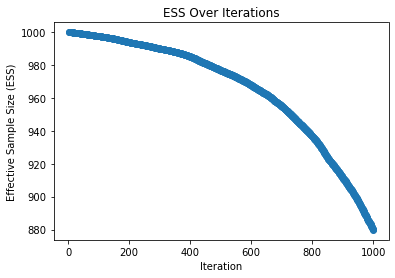

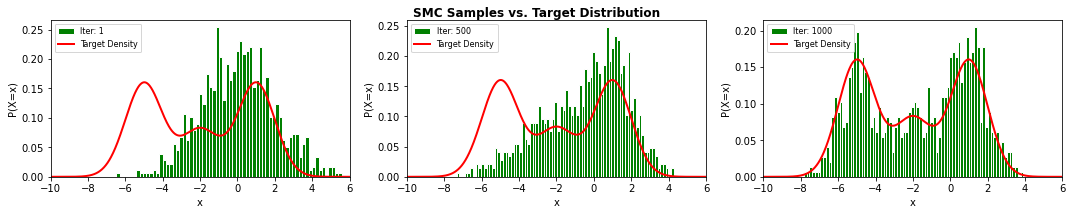

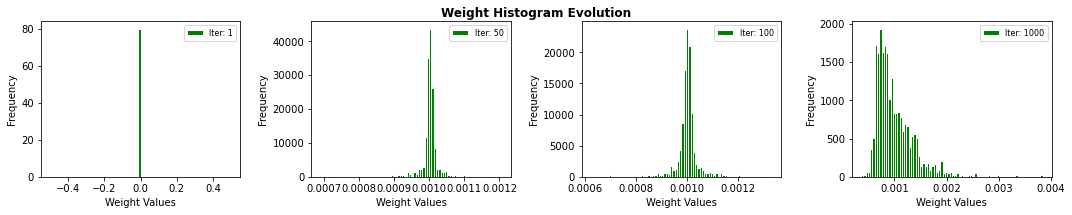

In [8]:
np.random.seed(42)
T = 1000
N = 1000

beta_seq = np.linspace(0, 1, T)

#target dist
def pi_target(x):
    return (
        0.4 * np.exp(-0.5 * ((x + 5) / 1)**2) / np.sqrt(2 * np.pi) +
        0.4 * np.exp(-0.5 * ((x - 1) / 1)**2) / np.sqrt(2 * np.pi) +
        0.2 * np.exp(-0.5 * ((x + 2) / 1)**2) / np.sqrt(2 * np.pi)
    )
# init dist
def pi_init(x):
    return np.exp(-0.5 * (x / 2)**2) / (2 * np.sqrt(2 * np.pi))

particles = np.random.normal(0, 2, N)

weights = np.ones(N) / N
particles_history = [particles.copy()]
ESS_history = np.zeros(T)
acceptance_rates = np.zeros(T)
weights_before_resampling = []

#initialisation
ESS = 1 / np.sum(weights**2)
ESS_history[0] = ESS
weights_before_resampling.append(weights.copy())
kl_list_vanilla=[]

# SMC sampler
for t in range(1, T):
    beta_prev = beta_seq[t - 1]
    beta_curr = beta_seq[t]
    beta_diff = beta_curr - beta_prev

    log_weights_increment = beta_diff * (np.log(pi_target(particles)) - np.log(pi_init(particles)))
    log_weights = np.log(weights) + log_weights_increment
    weights = np.exp(log_weights - np.max(log_weights))
    weights /= np.sum(weights)

    ESS = 1 / np.sum(weights**2)
    ESS_history[t] = ESS
    weights_before_resampling.append(weights.copy())

    ESS_threshold = N / 2
    if ESS < ESS_threshold:
        indices = np.random.choice(np.arange(N), size=N, replace=True, p=weights)
        particles = particles[indices]
        weights = np.ones(N) / N

    proposal_sd = 0.5
    proposed_particles = particles + np.random.normal(0, proposal_sd, N)

    log_pi_proposed = (1 - beta_curr) * np.log(pi_init(proposed_particles)) + \
                      beta_curr * np.log(pi_target(proposed_particles))
    log_pi_current = (1 - beta_curr) * np.log(pi_init(particles)) + \
                     beta_curr * np.log(pi_target(particles))
    log_accept_prob = log_pi_proposed - log_pi_current

    accept = np.log(np.random.uniform(size=N)) < log_accept_prob
    acceptance_rate = np.mean(accept)
    acceptance_rates[t] = acceptance_rate
    particles[accept] = proposed_particles[accept]


    particles_history.append(particles.copy())
    kl_list_vanilla.append(compute_kl_divergence(pi_target, particles, np.linspace(-10, 6, 1000)))
final_particles = particles



#ESS vs. Iterations
plt.figure()
plt.plot(range(2, T+1), ESS_history[1:], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Effective Sample Size (ESS)")
plt.title("ESS Over Iterations")
plt.show()


#Particle Dist vs. Iterations
iterations_to_plot = [0, 499,999]
x_vals = np.linspace(-10, 6, 1000)
y_vals = pi_target(x_vals)

plt.figure(figsize=(15, 3))
for i, t in enumerate(iterations_to_plot, 1):
    plt.subplot(1, 3, i)
    plt.hist(particles_history[t], bins=80, density=True, color='green', edgecolor='white',label=f'Iter: {t+1}')
    plt.plot(x_vals, y_vals, color='red', lw=2, label="Target Density")
    # plt.title(f"Iteration {t+1}")
    plt.xlim(-10, 6)
    plt.xlabel("x")
    plt.ylabel("P(X=x)")
    plt.legend(fontsize = 8)
plt.tight_layout(rect=[0, 0, 1, 0.97]) 
plt.suptitle("SMC Samples vs. Target Distribution", fontsize = 12, fontweight = 'bold')
plt.show()

iterations_to_plotw = [0, 49,99,999]
plt.figure(figsize=(15, 3))
for i, t in enumerate(iterations_to_plotw, 1):
    plt.subplot(1, 4, i)
    plt.hist(weights_before_resampling[t], bins=80, density=True, color='green', edgecolor='white',label=f'Iter: {t+1}')
    plt.xlabel("Weight Values")
    plt.ylabel("Frequency")
    plt.legend(fontsize = 8)
plt.tight_layout(rect=[0, 0, 1, 0.97]) 
plt.suptitle("Weight Histogram Evolution", fontsize = 12, fontweight = 'bold')
plt.show()




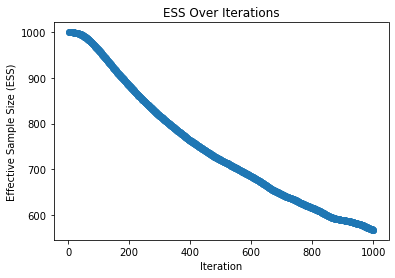

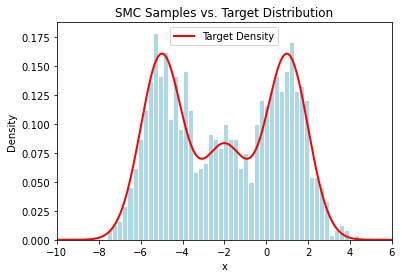

In [9]:
np.random.seed(123)
N = 1000
T = 1000
beta_seq = np.linspace(0, 1, T)

def pi_target(x):
    return (
        0.4 * np.exp(-0.5 * ((x + 5) / 1)**2) / np.sqrt(2 * np.pi) +
        0.4 * np.exp(-0.5 * ((x - 1) / 1)**2) / np.sqrt(2 * np.pi) +
        0.2 * np.exp(-0.5 * ((x + 2) / 1)**2) / np.sqrt(2 * np.pi)
    )

def pi_init(x):
    return np.exp(-0.5 * (x / 2)**2) / (2 * np.sqrt(2 * np.pi))

particles = np.random.normal(0, 2, N)

weights = np.ones(N) / N

particles_history = [particles.copy()]
ESS_history = np.zeros(T)
weights_before_resampling = []

ESS = 1 / np.sum(weights**2)
ESS_history[0] = ESS
weights_before_resampling.append(weights.copy())
kl_optimalkernel = []
# SMC sampler
for t in range(1, T):
    beta_prev = beta_seq[t - 1]
    beta_curr = beta_seq[t]
    beta_diff = beta_curr - beta_prev

    log_weights_increment = beta_diff * (np.log(pi_target(particles)) - np.log(pi_init(particles)))
    log_weights = np.log(weights) + log_weights_increment
    weights = np.exp(log_weights - np.max(log_weights))
    weights /= np.sum(weights)

    ESS = 1 / np.sum(weights**2)
    ESS_history[t] = ESS

    weights_before_resampling.append(weights.copy())

    ESS_threshold = N / 2
    if ESS < ESS_threshold:
        indices = np.random.choice(np.arange(N), size=N, replace=True, p=weights)
        particles = particles[indices]
        weights = np.ones(N) / N

    # MCMC LOcal Move: apply optimal kernel
    proposal_sd = 0.5
    proposed_particles = particles + np.random.normal(0, proposal_sd, N)

    #  (Optimal Backward Kernels)
    log_pi_proposed = beta_curr * np.log(pi_target(proposed_particles))
    log_pi_current = beta_curr * np.log(pi_target(particles))
    log_accept_prob = log_pi_proposed - log_pi_current

    accept = np.log(np.random.uniform(size=N)) < log_accept_prob
    particles[accept] = proposed_particles[accept]
    particles_history.append(particles.copy())
    kl_optimalkernel.append(compute_kl_divergence(pi_target, particles, np.linspace(-10, 6, 1000)))

final_particles = particles

plt.figure()
plt.plot(range(2, T+1), ESS_history[1:], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Effective Sample Size (ESS)")
plt.title("ESS Over Iterations")
plt.show()

x_vals = np.linspace(-10, 6, 1000)
y_vals = pi_target(x_vals)

plt.figure()
plt.hist(final_particles, bins=50, density=True, color='lightblue', edgecolor='white')
plt.plot(x_vals, y_vals, color='red', lw=2)
plt.title("SMC Samples vs. Target Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend(["Target Density"])
plt.xlim(-10, 6)
plt.show()


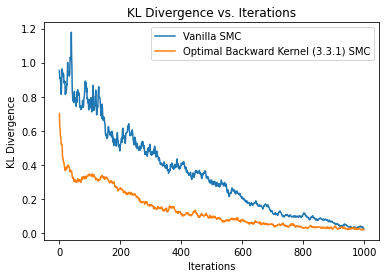

In [10]:
#figure 2 plots KL divergence
plt.plot(range(len(kl_list_vanilla)),kl_list_vanilla, label='Vanilla SMC')
plt.plot(range(len(kl_list_vanilla)),kl_optimalkernel, label='Optimal Backward Kernel (3.3.1) SMC')
plt.title('KL Divergence vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('KL Divergence')
plt.legend()
plt.show()